In [1]:
%pylab inline
import torch
from torch import nn, autograd
from torch.autograd import Variable
try:
    from tqdm import tqdm_notebook as tqdm
except ImportError:
    def tqdm(x,*arg,**kwargs):
        return x
#     tqdm = lambda x,:x
    print("Won't be using tqdm for progress bars")
    

import numpy as np
import pylab as plt
import torch.nn.init,torch.optim.lr_scheduler
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
"""
    Predicting the transfer matrix W and bias b from observations 
    of y = Wx+b. 
    b and y are vectors in R^{D_out}
    x is a vector in R^{D_in}
    W is a D_in x D_out matrix
"""

# number of dimensions input
D_in = 3
# number of dimensions output
D_out = 3
# entries in the matrix
D_m = max(D_in,D_out)+1
# num observations
N = D_m

In [3]:
W_real = torch.randn(D_out,D_in)
x = torch.randn(D_in,N)
x


 0.4143  0.2539 -0.6942  1.5874
 0.9564  0.5162 -0.2574  0.2715
 0.0195 -0.7924 -1.0685 -0.5001
[torch.FloatTensor of size 3x4]

In [4]:
y = torch.mm(W_real,x)
y


-1.0010 -0.0470  1.1091 -0.4082
-1.6040 -1.1536  0.3759 -1.3946
 0.2617  0.9521  1.1282  0.2940
[torch.FloatTensor of size 3x4]

In [5]:
# learning rate
lr = 1e-2
# define variables for autograd
x_v = Variable(x.transpose(1,0))
y_v = Variable(y.transpose(1,0))

In [6]:
# define a linear model (y = Wx+b)
model = torch.nn.Linear(D_in, D_out,bias = False)
model(x_v)

Variable containing:
 0.0593  0.0507 -0.6215
-0.2454 -0.0019 -0.0467
-0.1202 -0.2269  0.7185
-0.7705  0.4025 -0.3881
[torch.FloatTensor of size 4x3]

In [7]:
loss_fn = torch.nn.MSELoss(size_average=False)
loss_true = lambda : ((model.parameters().next().data-W_real)**2).sum()
model.train()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(10001):
    y_pred = model(x_v)
    loss = loss_fn(y_pred, y_v)
    if epoch%1000==0:
        print("progress:", "epoch:", epoch, "loss",loss.data[0], "true loss",loss_true())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
# After training
print("estimated parameters:")
for param in model.parameters():
    print(param)

('progress:', 'epoch:', 0, 'loss', 12.874539375305176, 'true loss', 6.134338420815766)
('progress:', 'epoch:', 1000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 2000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 3000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 4000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 5000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 6000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 7000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 8000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 9000, 'loss', 2.454882130908942e-11, 'true loss', 2.887290406761167e-11)
('progress:', 'epoch:', 10000, 'loss', 2

In [8]:
print(W_real)


-0.2996 -0.9040 -0.6256
-0.5225 -1.4577  0.3388
-0.2005  0.3813 -1.0174
[torch.FloatTensor of size 3x3]



So, N+1 records are (obviously) enough. Turns out that N are not rally enough (try)

## Questions 

### Deterministic problems

1. The convergence rate of loss from y and y_pred *versus* loss from W and W_estimated is the same?
2. Stationary loss when we have less than N records
3. When records < N, which ensamble of matrices I get? 

### Stochastic problems

4. A noisy model: y = Wx+b+eta
4b. Cross-validation

## Answers

### Deterministic problems

#### Q1. Converge rate y vs ypred and W vs Wpred

In [11]:
def Q1(D_in=D_in,D_out=D_out,optimizer_algo=None,seed=seed):
    if seed:
        torch.manual_seed(seed)
    # number of equations needed to solve the linear system
    N = max(D_in,D_out)+1
    # validation test
    Nval = max(1,int(N/3.))
    # a random gaussian matrix defines the linear system
    W_real = torch.randn(D_out,D_in)
    # input vectors
    x = torch.randn(D_in,N)
    # validation input vectors 
    xval = torch.randn(D_in,Nval)
    # output vectors
    y = torch.mm(W_real,x)
    # validation output vectors
    yval = torch.mm(W_real,xval)
    # learning rate
    lr = 1e-2
    # define variables for autograd
    # transpose becasue matmul takes dimensions first, variable takes realizations first
    x_v = Variable(x.transpose(1,0))
    y_v = Variable(y.transpose(1,0))
    xval = Variable(xval.transpose(1,0))
    yval = Variable(yval.transpose(1,0))
    # define a linear model (y = Wx+b)
    model = torch.nn.Linear(D_in, D_out,bias = False)
    # loss functions
    loss_fn = torch.nn.MSELoss(size_average=False)
    loss_true = lambda : ((model.parameters().next().data-W_real)**2).sum()**.5/D_out/D_in
    # set model in train mode
    model.train()
    # define the stoch grad descend optimizer
    optimizer = optimizer_algo(model.parameters(),lr=lr)
    # max epochs
    epochs = 10001
    # save losses
    loss_yypred=np.zeros(epochs)*np.nan
    loss_wwpred=np.zeros(epochs)*np.nan
    loss_val=np.zeros(epochs)*np.nan
    
    prev_loss=np.inf
    for epoch in range(epochs):
        y_pred = model(x_v)
        loss = loss_fn(y_pred, y_v)
        lossw = loss_true()
        current_loss = loss.data.numpy()[0]
        if prev_loss < current_loss:break
            
        prev_loss = current_loss
        loss_yypred[epoch]=current_loss
        loss_wwpred[epoch]=lossw
        
        loss_val[epoch]=(((model(xval)-yval)**2).sum()**.5).data[0]/Nval
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss_yypred,loss_wwpred,loss_val

##### Optimize with Adam

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

/home/astyonax/.anaconda/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


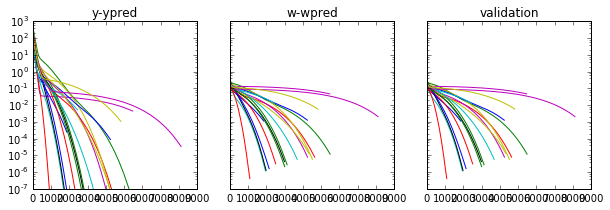

In [12]:
fig, (ax,bx,cx)=plt.subplots(1,3,figsize=(10,3),sharex='all',sharey='all')

for seed in tqdm(range(20),leave=0):
    loss_yypred,loss_wwpred,loss_val = Q1(5,5,optimizer_algo=torch.optim.Adam,seed=seed)
    ax.plot(loss_yypred)
    bx.plot(loss_wwpred)
    cx.plot(loss_wwpred)
    
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
cx.set_title('validation')
fig.suptitle='Inital conditions'

A Jupyter Widget

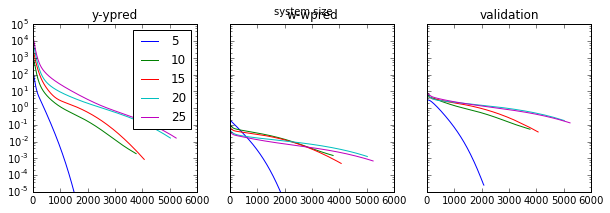

In [13]:
fig, (ax,bx,cx)=plt.subplots(1,3,figsize=(10,3),sharex='all',sharey='all')

for j in tqdm(range(1,6),leave=0):
    j=j*5
    loss_yypred,loss_wwpred, loss_val = Q1(j,j,optimizer_algo=torch.optim.Adam,seed=1234)
    ax.plot(loss_yypred,label=str(j))
    bx.plot(loss_wwpred)
    cx.plot(loss_val)
    
ax.legend(loc='best')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
cx.set_title('validation')
fig.suptitle('system size')

Ah! error on validation increases with system size?? is my normalization wrong?

##### Try with ASGD

A Jupyter Widget

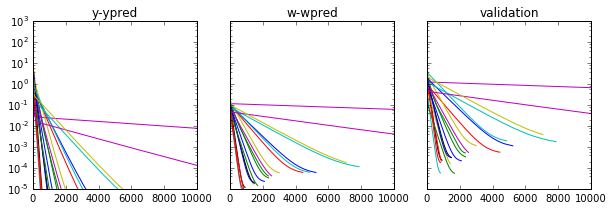

In [14]:
fig, (ax,bx,cx)=plt.subplots(1,3,figsize=(10,3),sharex='all',sharey='all')

for seed in tqdm(range(20),leave=0):
    loss_yypred,loss_wwpred,loss_val = Q1(5,5,optimizer_algo=torch.optim.ASGD,seed=seed)
    ax.plot(loss_yypred)
    bx.plot(loss_wwpred)
    cx.plot(loss_val)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
cx.set_title('validation')
fig.suptitle='Inital conditions'

##### Initialize with Xavier & use scheduler for lr

In [13]:
def Q1b(D_in=D_in,D_out=D_out,optimizer_algo=None,doscheduler=False,seed=0):
    if seed:
        torch.manual_seed(seed)
    # number of equations needed to solve the linear system
    N = max(D_in,D_out)+1
    # validation test
    Nval = max(1,int(N/3.))
    # a random gaussian matrix defines the linear system
    W_real = torch.randn(D_out,D_in)
    # input vectors
    x = torch.randn(D_in,N)
    # validation input vectors 
    xval = torch.randn(D_in,Nval)
    # output vectors
    y = torch.mm(W_real,x)
    # validation output vectors
    yval = torch.mm(W_real,xval)
    # learning rate
    lr = 1e-2
    # define variables for autograd
    # transpose becasue matmul takes dimensions first, variable takes realizations first
    x_v = Variable(x.transpose(1,0))
    y_v = Variable(y.transpose(1,0))
    xval = Variable(xval.transpose(1,0))
    yval = Variable(yval.transpose(1,0))
    # define a linear model (y = Wx+b)
    model = torch.nn.Linear(D_in, D_out,bias = False)
    params = model.parameters().next()
    torch.nn.init.kaiming_normal(params)
    model.weight = params
    # loss functions
    loss_fn = torch.nn.MSELoss(size_average=False)
    loss_true = lambda : ((model.parameters().next().data-W_real)**2).sum()**.5/D_out/D_in
    # set model in train mode
    model.train()
    # define the stoch grad descend optimizer
#     optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    optimizer = optimizer_algo(model.parameters(),lr=lr)
    # learning rate scheduler (which wraps the optimizer)
    if doscheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
    # max epochs
    epochs = 100000
    # save losses
    loss_yypred=np.zeros(epochs)*np.nan
    loss_wwpred=np.zeros(epochs)*np.nan
    loss_val=np.zeros(epochs)*np.nan
    
    prev_loss=np.inf
    for epoch in range(epochs):
        y_pred = model(x_v)
        loss = loss_fn(y_pred, y_v)
        lossw = loss_true()
        current_loss = loss.data.numpy()[0]
#         if prev_loss < current_loss:break
        if current_loss < 1e-7:break
            
        prev_loss = current_loss
        loss_yypred[epoch]=current_loss
        loss_wwpred[epoch]=lossw
        loss_val[epoch]=(((model(xval)-yval)**2).sum()**.5).data[0]/Nval
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if doscheduler:
            scheduler.step(loss)
    return loss_yypred,loss_wwpred,loss_val

##### Xavier w/o scheduler and SGD

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

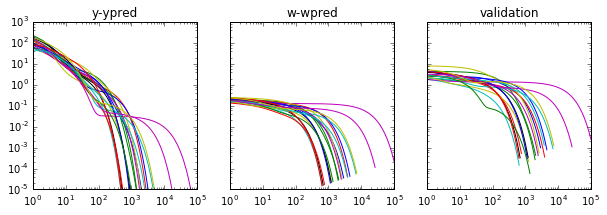

In [14]:
fig, (ax,bx,cx)=plt.subplots(1,3,figsize=(10,3),sharex='all',sharey='all')

for seed in tqdm(range(20),leave=0):
    loss_yypred,loss_wwpred,loss_val = Q1b(5,5,optimizer_algo=torch.optim.SGD,seed=seed)
    ax.plot(loss_yypred)
    bx.plot(loss_wwpred)
    cx.plot(loss_val)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
cx.set_title('validation')
fig.suptitle='Inital conditions'


##### Xavier w scheduler and SGD

In [ ]:
# fig, (ax,bx,cx)=plt.subplots(1,3,figsize=(10,3),sharex='all',sharey='all')

# for seed in tqdm(range(20),leave=0):
#     loss_yypred,loss_wwpred,loss_val = Q1b(5,5,optimizer_algo=torch.optim.SGD,doscheduler=True,seed=seed)
#     ax.plot(loss_yypred)
#     bx.plot(loss_wwpred)
#     cx.plot(loss_val)

# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_title('y-ypred')
# bx.set_title('w-wpred')
# cx.set_title('validation')
# fig.suptitle='Inital conditions'


##### X w/ S + A

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

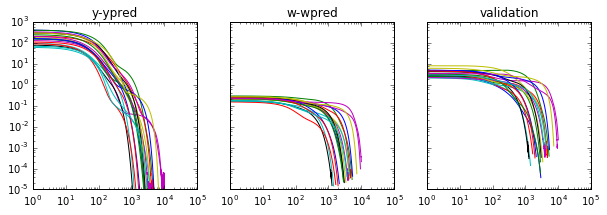

In [16]:
fig, (ax,bx,cx)=plt.subplots(1,3,figsize=(10,3),sharex='all',sharey='all')

for seed in tqdm(range(20)):
    loss_yypred,loss_wwpred,loss_val = Q1b(5,5,optimizer_algo=torch.optim.Adam,seed=seed)
    ax.plot(loss_yypred)
    bx.plot(loss_wwpred)
    cx.plot(loss_val)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
cx.set_title('validation')
fig.suptitle='Inital conditions'


##### X w S + A

In [ ]:
# fig, (ax,bx,cx)=plt.subplots(1,3,figsize=(10,3),sharex='all',sharey='all')

# for seed in tqdm(range(20)):
#     loss_yypred,loss_wwpred,loss_val = Q1b(5,5,optimizer_algo=torch.optim.Adam,doscheduler=1,seed=seed)
#     ax.plot(loss_yypred)
#     bx.plot(loss_wwpred)
#     cx.plot(loss_val)

# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_title('y-ypred')
# bx.set_title('w-wpred')
# cx.set_title('validation')
# fig.suptitle='Inital conditions'


##### X w/ S + A - system size

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

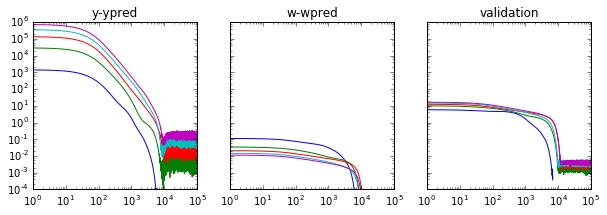

In [17]:
fig, (ax,bx,cx)=plt.subplots(1,3,figsize=(10,3),sharex='all',sharey='all')

for j in tqdm(range(1,10,2),leave=0):
    j *=10
    loss_yypred,loss_wwpred,loss_val = Q1b(j,j,optimizer_algo=torch.optim.Adam,seed=1234)
    ax.plot(loss_yypred)
    bx.plot(loss_wwpred)
    cx.plot(loss_val)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
cx.set_title('validation')
fig.suptitle='Inital conditions'


`w-wpred` shows that the error per entry in the predicted matrix is about constant wrt matrix size. Good

##### Conclusions #1

So the ASGD is faster than ADAM, the scheduler does nothing in this case and we predict the transfer matrix with N+1 constraints. Validation set follows expected error on matrix.

**Scheduler throws a runtime error**

### Q2  N-n records, 0<n<N

In [7]:
def Q2(n=1,D_in=D_in,D_out=D_out,seed=0):
    # number of equations: N_frac by the minimum number needed to solve the system with linear algebra
    N = n
    # define a seed for reproducibility
    if seed:
        torch.manual_seed(seed)
    # a random gaussian linear system
    W_real = torch.randn(D_out,D_in)
    # input vectors
    x = torch.randn(D_in,N)
    # output vectors
    y = torch.mm(W_real,x)
    # learning rate
    lr = 1e-2
    # define variables for autograd
    # transpose: see comment in Q1
    x_v = Variable(x.transpose(1,0))
    y_v = Variable(y.transpose(1,0))
    # define a linear model (y = Wx+b)
    if seed:
        torch.manual_seed(seed*2)
    model = torch.nn.Linear(D_in, D_out,bias = False)
    params = model.parameters().next()
    torch.nn.init.kaiming_normal(params)
    model.weight = params
    
    # loss functions
    loss_fn = torch.nn.MSELoss(size_average=False)
#     loss_fn = torch.nn.KLDivLoss()
    loss_true = lambda : ((model.parameters().next().data-W_real)**2).mean()**.5
    # set model in train mode
    model.train()
    # define the stoch grad descend optimizer
    # in Q1 we saw its faster
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    # max epochs
    epochs = 10001
    # save losses
    loss_yypred=np.zeros(epochs)
    loss_wwpred=np.zeros(epochs)

    for epoch in range(epochs):
        y_pred = model(x_v)
        loss = loss_fn(y_pred, y_v)
        lossw = loss_true()
        current_loss = loss.data.numpy()[0]
        loss_yypred[epoch] = current_loss
        loss_wwpred[epoch] = lossw
        if current_loss < 1e-7:break
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss_yypred,loss_wwpred,W_real,model.parameters().next().data

HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

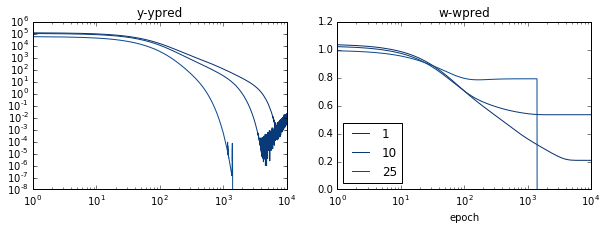

In [8]:
fig, (ax,bx)=plt.subplots(1,2,figsize=(10,3),sharex='all')

for frac in tqdm([25,10,1],leave=0):
    loss_yypred,loss_wwpred,W_real,W_pred = Q2(50-frac,50,50)
    ax.plot(loss_yypred,c=plt.cm.Blues_r(frac))
    bx.plot(loss_wwpred,c=plt.cm.Blues_r(frac),label=str(frac))

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
bx.legend(loc='best')
bx.set_xlabel('epoch')

(<matplotlib.text.Text at 0x7f2f6ae1c510>,
 <matplotlib.text.Text at 0x7f2f6a968d10>)

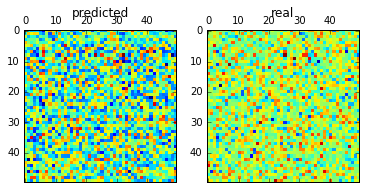

In [26]:
fig,(ax,bx)=plt.subplots(1,2)
ax.matshow(W_pred.numpy()),bx.matshow(W_real.numpy())
ax.set_title('predicted'),bx.set_title('real')

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=7), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=7), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=7), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=7), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=7), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=7), HTML(value=u'')))

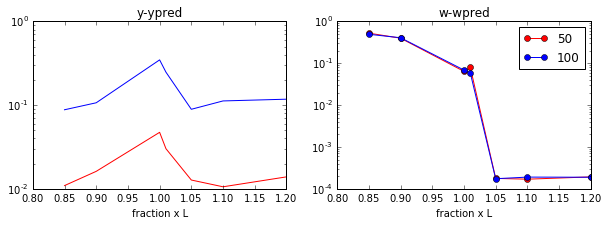

In [10]:
fig, (ax,bx)=plt.subplots(1,2,figsize=(10,3),sharex='all')

fracs = [1.2,1.1,1.05,1.01,1.,.9,.85]
for j,c in tqdm(zip([50,100],['r','b']),leave=0):
    
    y = []
    w = []
    for _ in xrange(3):
        y_atend=[]
        w_atend=[]
        for frac in tqdm(fracs,leave=0):
            loss_yypred,loss_wwpred,_,_ = Q2(int(frac*j),j,j)
            y_atend.append(loss_yypred[-1])
            w_atend.append(loss_wwpred[-1])
        y.append(y_atend)
        w.append(w_atend)
        
    y = np.mean(y,axis=0)
    w = np.mean(w,axis=0)
    ax.plot(fracs,y,c=c)
    bx.plot(fracs,w,'o-',c=c,label=str(j))
    
ax.set_yscale('log')
bx.set_yscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
bx.legend(loc='best')
ax.set_xlabel('fraction')
bx.set_xlabel('fraction')

... so ? back to stat. mech 101 !! :)


### Q3 Noise

In [5]:
def Q3(n=1,D_in=D_in,D_out=D_out,seed=0,noise=0,epochs=1000):
    N = n
    if seed:
        torch.manual_seed(seed)
    W_real = torch.randn(D_out,D_in)
    x = torch.randn(D_in,N)
    eta = torch.randn(D_in,N)*noise
    y = torch.matmul(W_real,x)+eta
    # learning rate
    lr = 1e-3
    # define variables for autograd
    x_v = Variable(x.transpose(1,0))
    y_v = Variable(y.transpose(1,0))
    # define a linear model (y = Wx+b)
    model = torch.nn.Linear(D_in, D_out,bias = False)
    params = model.parameters().next()
    torch.nn.init.kaiming_normal(params)
    model.weight = params
    # loss functions
    loss_fn = torch.nn.MSELoss(size_average=False)
    loss_true = lambda : ((model.parameters().next().data-W_real)**2).mean()**.5
    # set model in train mode
    model.train()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    # max epochs
#     epochs = 10001
    # save losses
    loss_yypred=np.zeros(epochs)
    loss_wwpred=np.zeros(epochs)

    for epoch in range(epochs):
        y_pred = model(x_v)
        loss = loss_fn(y_pred, y_v)
        lossw = loss_true()
        current_loss = loss.data.numpy()[0]
        loss_yypred[epoch] = current_loss
        loss_wwpred[epoch] = lossw
        if current_loss < 1e-4:break
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss_yypred,loss_wwpred,W_real,model.parameters().next().data

In [35]:
fracs = [1.2,1.1,1.05,1.01,1.,.95,.9,.85]
out = {}

lastnonzero = lambda x : x[np.nonzero(x)[0][-1]]

for j in tqdm([.01,.1,.5,1],leave=0):
    
    y = []
    w = []
    for _ in tqdm(range(20),leave=0):
        y_atend=[]
        w_atend=[]
        for frac in tqdm(fracs,leave=0):
            loss_yypred,loss_wwpred,_,_ = Q3(int(frac*50),50,50,noise=j,epochs=20000)
            y_atend.append(lastnonzero(loss_yypred))
            w_atend.append(lastnonzero(loss_wwpred))
        y.append(y_atend)
        w.append(w_atend)
        
    y = np.mean(y,axis=0)
    w = np.mean(w,axis=0)
    out[j]=(y,w)

    with open('Q3_data.pkl','wb') as fout:
        pkl.dump([out,fracs],fout)


HBox(children=(IntProgress(value=0, max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

KeyboardInterrupt: 

Text(0.5,0,u'fraction')

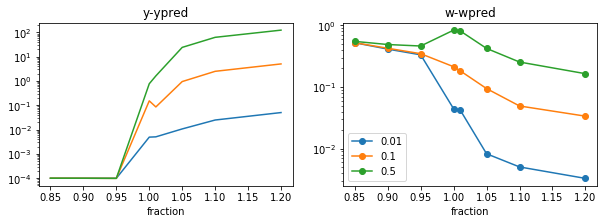

In [36]:
fig, (ax,bx)=plt.subplots(1,2,figsize=(10,3),sharex='all')

for key in sorted(out.keys()):
    (y,w) = out[key]
    ax.plot(fracs,y)
    bx.plot(fracs,w,'o-',label=str(key))
    
ax.set_yscale('log')
bx.set_yscale('log')
ax.set_title('y-ypred')
bx.set_title('w-wpred')
bx.legend(loc='best')
ax.set_xlabel('fraction')
bx.set_xlabel('fraction')

no cross validation. We are learning the noise when fraction<100% .


## Q4 Noise and CV

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
set([32, 33, 34, 3, 36, 9, 10, 43, 12, 2, 14, 16, 11, 46, 22, 23, 24, 26, 42, 30]) set([0, 1, 4, 5, 6, 7, 8, 13, 15, 17, 18, 19, 20, 21, 25, 27, 28, 29, 31, 35, 37, 38, 39, 40, 41, 44, 45, 47, 48, 49])


In [141]:
def Q4(n=1,test_size=.4,D_in=50,seed=0,noise=0,epochs=1000):
    N = int((n+test_size)*D_in)
    
    if seed:
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    W_real = torch.randn(D_in,D_in)
    x = torch.randn(D_in,N)
    eta = torch.randn(D_in,N)*noise
    y = torch.matmul(W_real,x)+eta
    # learning rate
    lr = 1e-3
    # define train set and test set
    all_idx = set(np.arange(N,dtype=int))
    test_idx = set(np.random.choice(N,int(N*test_size),replace=0))
    train_idx = list(all_idx-test_idx)
    test_idx  = list(test_idx)
    print 'test size',len(test_idx)
    print 'train size',len(train_idx)
    x_test = x[:,test_idx]
    y_test = y[:,test_idx]
    x = x[:,train_idx]
    y = y[:,train_idx]
    
    # define variables for autograd
    x_v = Variable(x.transpose(1,0))
    y_v = Variable(y.transpose(1,0))

    x_test_v = Variable(x_test.transpose(1,0))
    y_test_v = Variable(y_test.transpose(1,0))
    # define a linear model (y = Wx+b)
    model = torch.nn.Linear(D_in, D_in,bias = False)
    params = model.parameters().next()
    torch.nn.init.kaiming_normal(params)
    model.weight = params
    # loss functions
    loss_fn = torch.nn.MSELoss(size_average=False)
    loss_true = lambda : ((model.parameters().next().data-W_real)**2).mean()**.5
    loss_test_fn = lambda : ((model(x_test_v)-y_test_v).data**2).mean()**.5
    # set model in train mode
#     model.train()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    # max epochs
#     epochs = 10001
    # save losses
    loss_yypred=np.zeros(epochs)
    loss_wwpred=np.zeros(epochs)
    loss_test  =np.zeros(epochs)
    
    for epoch in range(epochs):
        y_pred = model(x_v)
        loss = loss_fn(y_pred, y_v)
        lossw = loss_true()
        current_loss = loss.data.numpy()[0]
        loss_yypred[epoch] = current_loss
        loss_wwpred[epoch] = lossw
        loss_test[epoch]=loss_test_fn()
        
        if current_loss < 1e-4:break
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    return loss_yypred[:epoch],loss_wwpred[:epoch],loss_test[:epoch]#,W_real,model.parameters().next().data

In [146]:
loss_y,loss_w,loss_t = Q4(2,epochs=25000)

test size 48
train size 72


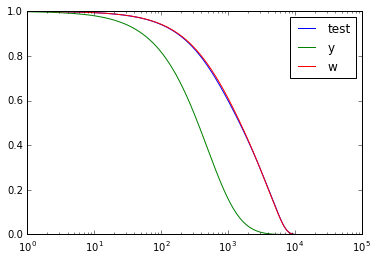

In [147]:

plt.plot(loss_t/loss_t[0],label="test")
plt.plot(loss_y/loss_y[0],label="y")
plt.semilogx(loss_w/loss_w[0],label="w")
plt.legend()

In [150]:
loss_y,loss_w,loss_t = Q4(.2,epochs=25000)

test size 12
train size 18


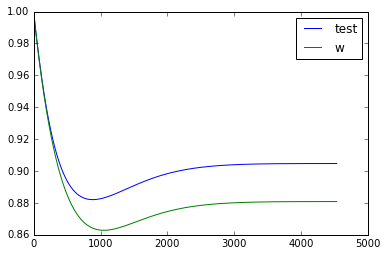

In [151]:

plt.plot(loss_t/loss_t[0],label="test")
# plt.plot(loss_y/loss_y[0],label="y")
plt.plot(loss_w/loss_w[0],label="w")
plt.legend()

test size 35
train size 54
test size 35
train size 54
test size 35
train size 54


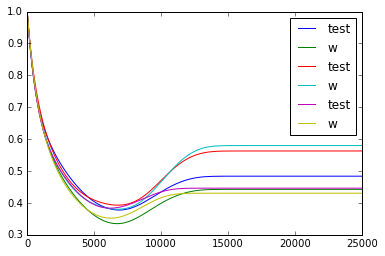

In [161]:
for _ in range(3):
    loss_y,loss_w,loss_t = Q4(1.4,epochs=25000,noise=1)
    plt.plot(loss_t/loss_t[0],label="test")
    # plt.plot(loss_y/loss_y[0],label="y")
    plt.plot(loss_w/loss_w[0],label="w")
    plt.legend()

test size 22
train size 33
test size 22
train size 33
test size 22
train size 33


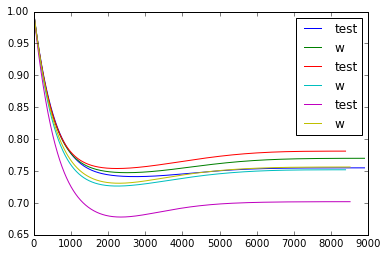

In [162]:
for _ in range(3):
    loss_y,loss_w,loss_t = Q4(.7,epochs=25000,noise=1)
    plt.plot(loss_t/loss_t[0],label="test")
    # plt.plot(loss_y/loss_y[0],label="y")
    plt.plot(loss_w/loss_w[0],label="w")
    plt.legend()